# Neural Network Model Tuning

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is with new features and hyperparameter tuning on Neural Network

# Table of Contents

### - [Neural Net Architecture](#NN)

### - [SHAP Values for Feature Importance](#SHAP)

### - [HyperParemeter Tuning with Grid Search](#GRID)

### - [Best Model Results](#RESULTS)

### - [Confusion Matrix](#matrix)

### - [Prior Iterations](#prior)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [2]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim
import shap

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

2

In [5]:
torch.device('cuda')

device(type='cuda')

In [6]:
#df = modelDataI=gpd.read_parquet("../../data/staley16_observations_catchment_fuelpars_rocktype_randn_v3.parquet")
#df = modelDataI=gpd.read_parquet("../../data/staley16_observations_catchment_fuelpars_rocktype_randn_lndslide_v5.parquet")
df = modelDataI=gpd.read_parquet("../../data/staley16_observations_catchment_fuelpars_rocktype_randn_lndslide_fireinterval_v6.parquet")
print('raw data -',df.shape)

df=df.dropna()
print('after nulls removed -',df.shape)

# #store clean data to file, this will be used as input to model
# df.to_csv("../../data/ST16-observations-new-features-v3-na-omit.csv", index=False)

raw data - (1379, 49)
after nulls removed - (1078, 49)


In [7]:
df.head()

fire_name  year fire_id fire_segid  database state  response  stormdate  \
0  Buckweed  2007     bck   bck_1035  Training    CA         0         22   
1  Buckweed  2007     bck   bck_1090  Training    CA         0         22   
2  Buckweed  2007     bck   bck_1570  Training    CA         0         22   
3  Buckweed  2007     bck    bck_235  Training    CA         0         22   
4  Buckweed  2007     bck    bck_363  Training    CA         0         22   

   gaugedist_m          stormstart  ... Igneous  Metamorphic  Sedimentary  \
0      1998.67 2008-01-21 16:27:00  ...     0.0     1.000000     0.000000   
1      2368.93 2008-01-21 16:27:00  ...     0.0     1.000000     0.000000   
2      3956.74 2008-01-21 16:27:00  ...     0.0     0.973247     0.026753   
3      1734.72 2008-01-21 15:47:00  ...     0.0     1.000000     0.000000   
4      1801.04 2008-01-21 15:47:00  ...     0.0     1.000000     0.000000   

   Unconsolidated        domrt  index_right     LNDS_RISKV  LNDS_RISKS  \
0             0.0  Metamorphic          205  380675.353544   96.305814   
1             0.0  Metamorphic          205  380675.353544   96.305814   
2             0.0  Metamorphic          205  380675.353544   96.305814   
3             0.0  Metamorphic          205  380675.353544   96.305814   
4             0.0  Metamorphic          205  380675.353544   96.305814   

        LNDS_RISKR  fire_interval  
0  Relatively High            1.0  
1  Relatively High            1.0  
2  Relatively High            1.0  
3  Relatively High            1.0  
4  Relatively High            1.0  

[5 rows x 49 columns]

In [8]:
df['state'].value_counts().sort_index()

AZ     84
CA    762
CO    180
NM     52
Name: state, dtype: int64

DR: suggests reducing the number of features
- consolidated to proportion of catchment dominated by grassland

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
df[['NB', 'GR', 'GS', 'SH', 'TU', 'TL', 'dom', 'domrt']].tail(10)

NB        GR        GS        SH        TU        TL  dom    domrt
1525  0.018989  0.544652  0.391939  0.014674  0.000000  0.029746  GR2  Igneous
1526  0.018989  0.544652  0.391939  0.014674  0.000000  0.029746  GR2  Igneous
1527  0.003347  0.579857  0.386675  0.017590  0.000000  0.012531  GR2  Igneous
1528  0.018904  0.643133  0.326389  0.000000  0.000000  0.011574  GR2  Igneous
1529  0.018904  0.643133  0.326389  0.000000  0.000000  0.011574  GR2  Igneous
1530  0.000000  0.000346  0.248639  0.053548  0.157330  0.540137  TL3  Igneous
1534  0.000000  0.000973  0.606123  0.064304  0.072473  0.256127  GS1  Igneous
1538  0.000000  0.029254  0.251282  0.100699  0.223310  0.395455  TL3  Igneous
1542  0.000000  0.177774  0.041012  0.009879  0.156307  0.615027  TL3  Igneous
1546  0.000000  0.028949  0.465287  0.085931  0.090254  0.329578  GS1  Igneous

In [11]:
# these are the ones to remove with dominant encoded features
grass_cols = ['NB', 'GR', 'GS', 'SH', 'TU', 'TL']
print(len(grass_cols))
print(sorted(grass_cols))

6
['GR', 'GS', 'NB', 'SH', 'TL', 'TU']


In [12]:
sorted(df['dom'].unique())

['GR1',
 'GR2',
 'GS1',
 'GS2',
 'NB1',
 'NB3',
 'SH2',
 'SH7',
 'TL3',
 'TL4',
 'TL8',
 'TU1',
 'TU5']

In [13]:
# this would actually be MORE columns
enc = OneHotEncoder()
enc.fit(df[['dom']])
enc_out = enc.transform(df[['dom']]).toarray()
enc_cols = enc.get_feature_names_out()
print(len(enc_cols))
enc_cols

13


array(['dom_GR1', 'dom_GR2', 'dom_GS1', 'dom_GS2', 'dom_NB1', 'dom_NB3',
       'dom_SH2', 'dom_SH7', 'dom_TL3', 'dom_TL4', 'dom_TL8', 'dom_TU1',
       'dom_TU5'], dtype=object)

In [14]:
# pd.DataFrame(enc_out, columns=enc_cols)

In [15]:
# try with one peak* feature and acc* feature 
features = [
    'peak_i15_mmh',
    'peak_i30_mmh', 
    'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    'acc015_mm', 
    'acc030_mm', 
    'acc060_mm', 
    'NB', # consolidated to one feature
    'GR', # consolidated to one feature
    'GS', # consolidated to one feature
    'SH', # consolidated to one feature
    'TU', # consolidated to one feature
    'TL', # consolidated to one feature
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated', 
    # 'dom', # this is encoded as proportion of grass
    # 'domrt', # this is encoded as proportion of rock
    'LNDS_RISKS',
    'fire_interval',
]

features_15 = [
    'peak_i15_mmh',
    # 'peak_i30_mmh', 
    # 'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    'acc015_mm',
    # 'acc030_mm', 
    # 'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL',
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated',
    # 'dom', # this is encoded as proportion of grass
    # 'domrt', # this is encoded as proportion of rock
    'LNDS_RISKS',
    'fire_interval',
]

features_30 = [
    # 'peak_i15_mmh',
    'peak_i30_mmh', 
    # 'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf',
    # 'acc015_mm', 
    'acc030_mm', 
    # 'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated', 
    # 'dom', # this is encoded as proportion of grass
    # 'domrt', # this is encoded as proportion of rock
    'LNDS_RISKS',
    'fire_interval',
]

features_60 = [
    # 'peak_i15_mmh',
    # 'peak_i30_mmh', 
    'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf',
    # 'acc015_mm', 
    # 'acc030_mm', 
    'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated',
    # 'dom', # this is encoded as proportion of grass
    # 'domrt', # this is encoded as proportion of rock
    'LNDS_RISKS',
    'fire_interval',
]


y = df['response']

## Neural Net <a id="NN">

In [16]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        # self.fc3 = nn.Linear(hidden_size, hidden_size)
        # self.relu3 = nn.ReLU()
        # self.dropout3 = nn.Dropout(dropout_rate) # dropout to prevent overfitting

        # self.fc4 = nn.Linear(hidden_size, hidden_size)
        # self.relu4 = nn.ReLU()
        # self.dropout4 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # output to probability rather than bool
        
        # Initilize weights with Glorot
        # need to decide on uniform vs normal distribution
        # UNIFORM
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)
        # nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        
        # NORMAL
        # nn.init.xavier_normal_(self.fc1.weight)
        # nn.init.xavier_normal_(self.fc2.weight)
        # nn.init.xavier_normal_(self.fc3.weight)
        # nn.init.xavier_normal_(self.fc4.weight)
        # nn.init.xavier_normal_(self.fc_out.weight)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        # out = self.fc2(out)
        # out = self.relu2(out)
        # out = self.dropout2(out)
        
        # out = self.fc3(out)
        # out = self.relu3(out)
        # out = self.dropout3(out)
        
        # out = self.fc4(out)
        # out = self.relu4(out)
        # out = self.dropout4(out)
        
        out = self.fc_out(out)
        out = self.sigmoid(out)      

        return out

Grid Search HyperParameters

In [17]:
n_epochs = 500

In [18]:
%%time
# GRID SEARCH CV

# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()

    X = data[features_15]
    y = data['response']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]
        
        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
        
        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
        # evaluating parameters on test accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params = params

        # evaluating parameters on test recall
        if test_recall_score > best_recall:
            best_recall = test_recall_score
            best_params = params
        
        # # evaluating parameters on test AUCy
        # if auc_test > best_auc:
        #     best_auc = auc_test
        #     best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')

    # AUC
    print("\n")
    print(f'AUC (test): {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print(f'F1 Score (test): {f1_output}')

best hyperparameters:
{'dropout_rate': 0.1, 'hidden_size': 500, 'lr': 0.001}
Training loss: 0.04707751423120499
Validation loss: 1.4210716485977173


Training accuracy: 0.9802784222737819
Test accuracy: 0.8009259259259259


AUC (test): 0.8333719180460701
F1 Score (test): 0.5376344086021505
CPU times: user 20min 55s, sys: 19.1 s, total: 21min 14s
Wall time: 1min 2s


In [19]:
param_grid

{'hidden_size': [10, 100, 250, 500],
 'dropout_rate': [0.05, 0.1, 0.15, 0.2],
 'lr': [0.0001, 0.001, 0.01]}

1,000 epochs (before landslide/fireinterval feature)

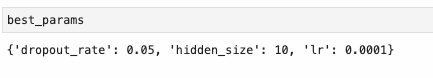

In [20]:
print(n_epochs)

500


## SHAP Values <a id="SHAP">
    
Examine the Shap values for feature importance
- we likely need to reduce the number of features to prevent overfitting

In [21]:
explainer = shap.DeepExplainer(model, X_train)

In [22]:
shap_values = explainer.shap_values(X_test)
shap_values

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([[ 7.33631402e-02,  3.17374617e-03,  1.36295915e-01, ...,
         4.19041291e-02,  6.62254840e-02,  1.16412036e-01],
       [ 7.99074844e-02,  8.60351231e-03,  4.38902788e-02, ...,
         1.04648396e-02,  2.73974985e-02, -7.47672170e-02],
       [-1.13145880e-01,  3.62178031e-03, -1.31106330e-02, ...,
        -1.69649115e-03, -2.31481623e-03, -1.33676436e-02],
       ...,
       [-1.28271148e-01, -1.45640196e-02, -4.89363670e-02, ...,
        -9.52560734e-03,  1.57463923e-02,  7.30098560e-02],
       [-2.22770259e-01, -6.67424966e-03,  2.83106118e-02, ...,
         5.39493485e-05, -1.48521992e-03, -2.49986746e-03],
       [-1.28350481e-01,  3.26263206e-03, -6.44617621e-03, ...,
        -1.86470395e-03, -3.08782008e-04, -1.09309983e-02]])

In [23]:
shap_values.shape

(216, 22)

In [24]:
vals = np.abs(shap_values).mean(0)
vals

array([0.11372731, 0.01974841, 0.04059811, 0.03558988, 0.03876381,
       0.03342924, 0.02305909, 0.02815706, 0.03517716, 0.01442398,
       0.0507145 , 0.03313743, 0.01972127, 0.02316381, 0.05221158,
       0.08331363, 0.03000031, 0.02143403, 0.03089057, 0.00827949,
       0.02351333, 0.03799705])

In [25]:
shap_val_df = pd.DataFrame(data=vals, index=features_15, columns=['vals'])
shap_val_df = shap_val_df.sort_values(by='vals', ascending=False)
shap_val_df

vals
peak_i15_mmh                 0.113727
Extinction moisture content  0.083314
Packing ratio                0.052212
TU                           0.050714
prophm23                     0.040598
kf                           0.038764
fire_interval                0.037997
dnbr1000                     0.035590
GS                           0.035177
acc015_mm                    0.033429
TL                           0.033137
Sedimentary                  0.030891
Igneous                      0.030000
GR                           0.028157
LNDS_RISKS                   0.023513
SAV                          0.023164
NB                           0.023059
Metamorphic                  0.021434
contributingarea_km2         0.019748
Fine fuel load               0.019721
SH                           0.014424
Unconsolidated               0.008279

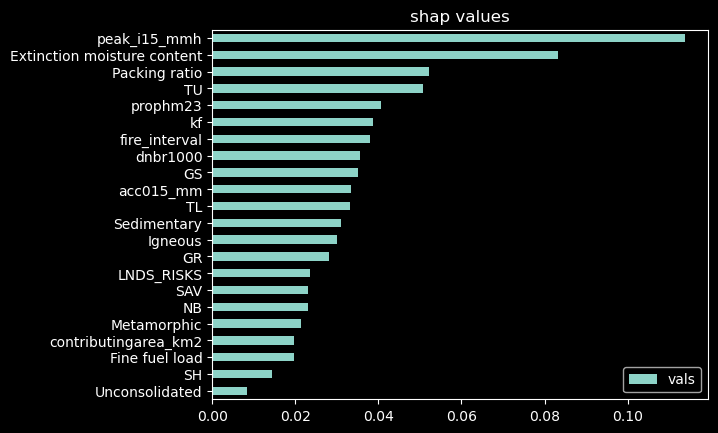

In [26]:
shap_val_df[::-1].plot(kind='barh', title='shap values');

In [27]:
feat_order = list(shap_val_df.index)
feat_order

['peak_i15_mmh',
 'Extinction moisture content',
 'Packing ratio',
 'TU',
 'prophm23',
 'kf',
 'fire_interval',
 'dnbr1000',
 'GS',
 'acc015_mm',
 'TL',
 'Sedimentary',
 'Igneous',
 'GR',
 'LNDS_RISKS',
 'SAV',
 'NB',
 'Metamorphic',
 'contributingarea_km2',
 'Fine fuel load',
 'SH',
 'Unconsolidated']

In [28]:
# generate incrementally longer feature lists in order of importance
cumulative_feature_list = []
for i, feat in enumerate(feat_order, 1):
    cumulative_feature_list.append(feat_order[:i])
cumulative_feature_list[:5]

[['peak_i15_mmh'],
 ['peak_i15_mmh', 'Extinction moisture content'],
 ['peak_i15_mmh', 'Extinction moisture content', 'Packing ratio'],
 ['peak_i15_mmh', 'Extinction moisture content', 'Packing ratio', 'TU'],
 ['peak_i15_mmh',
  'Extinction moisture content',
  'Packing ratio',
  'TU',
  'prophm23']]

In [29]:
# looks good
cumulative_feature_list[-1]

['peak_i15_mmh',
 'Extinction moisture content',
 'Packing ratio',
 'TU',
 'prophm23',
 'kf',
 'fire_interval',
 'dnbr1000',
 'GS',
 'acc015_mm',
 'TL',
 'Sedimentary',
 'Igneous',
 'GR',
 'LNDS_RISKS',
 'SAV',
 'NB',
 'Metamorphic',
 'contributingarea_km2',
 'Fine fuel load',
 'SH',
 'Unconsolidated']

In [30]:
feats = feat_order[:5]
feats

['peak_i15_mmh',
 'Extinction moisture content',
 'Packing ratio',
 'TU',
 'prophm23']

In [31]:
feat_of_feats = cumulative_feature_list[:10]
feat_of_feats[-1]

['peak_i15_mmh',
 'Extinction moisture content',
 'Packing ratio',
 'TU',
 'prophm23',
 'kf',
 'fire_interval',
 'dnbr1000',
 'GS',
 'acc015_mm']

## Grid Search HyperParameter Tuning <a id="GRID">

In [32]:
n_epochs = 500

In [33]:
%%time
# GRID SEARCH CV with feature selection

# 15 MIN
if __name__ == '__main__':

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    'features': feat_of_feats # list of lists
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        
        # Load data
        data = df.copy()

        X = data[params['features']]
        y = data['response']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        #scale the data X_train and X_test
        cols = X_train.columns
        sc = StandardScaler()
        X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
        X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

        X_train = torch.tensor(X_train.values).float()
        y_train = torch.tensor(y_train.values).float().view(-1, 1)
        X_test = torch.tensor(X_test.values).float()
        y_test = torch.tensor(y_test.values).float().view(-1, 1)
        
        
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]

        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
        
        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
        # # evaluating parameters on test accuracy
        # if test_accuracy > best_accuracy:
        #     best_accuracy = test_accuracy
        #     best_params = params

        # evaluating parameters on test recall
        if test_recall_score > best_recall:
            best_recall = test_recall_score
            best_params = params

        # # evaluating parameters on test AUC
        # if auc_test > best_auc:
        #     best_auc = auc_test
        #     best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('with feature selection')
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')
    
    # recall
    test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='micro')
    print("\n")
    print(f'Recall (test): {test_recall_score}')    
    
    # AUC
    print("\n")
    print(f'AUC (test): {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print(f'F1 Score (test): {f1_output}')

with feature selection
best hyperparameters:
{'dropout_rate': 0.05, 'features': ['peak_i15_mmh'], 'hidden_size': 10, 'lr': 0.0001}
Training loss: 0.11759507656097412
Validation loss: 0.872468888759613


Training accuracy: 0.9547563805104409
Test accuracy: 0.7870370370370371


Recall (test): 0.7870370370370371


AUC (test): 0.8274105799282324
F1 Score (test): 0.48888888888888893
CPU times: user 8h 58min 39s, sys: 3min 29s, total: 9h 2min 9s
Wall time: 43min 53s


In [34]:
len(best_params['features'])

1

In [52]:
# useful for upsizing number of epochs while testing

n_epochs = n_epochs
#n_epochs = 1_000
n_epochs = 5_000
#n_epochs = 10_000

## Best Model <a id="RESULTS">

hyperparameters:
{'dropout_rate': 0.05, 'features': ['peak_i15_mmh'], 'hidden_size': 10, 'lr': 0.0001}
epochs:  5000


Training loss: 0.4780314862728119
Validation loss: 0.4552674889564514


Training accuracy: 0.7517401392111369
Test accuracy: 0.7685185185185185


Recall (test): 0.16981132075471697


F1 Score (test): 0.2647058823529412
AUC (test): 0.7982405370992014


CPU times: user 39min 31s, sys: 15.4 s, total: 39min 47s
Wall time: 3min 20s


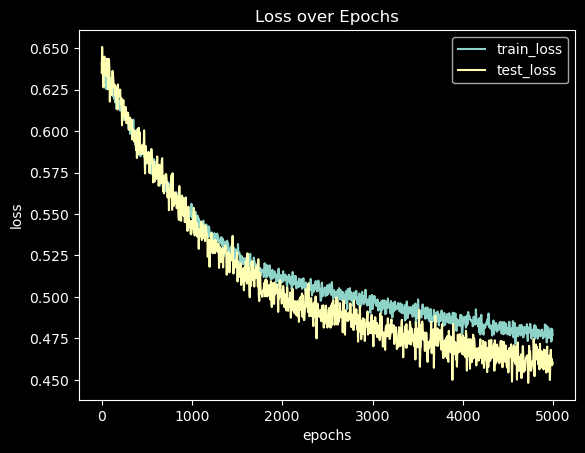

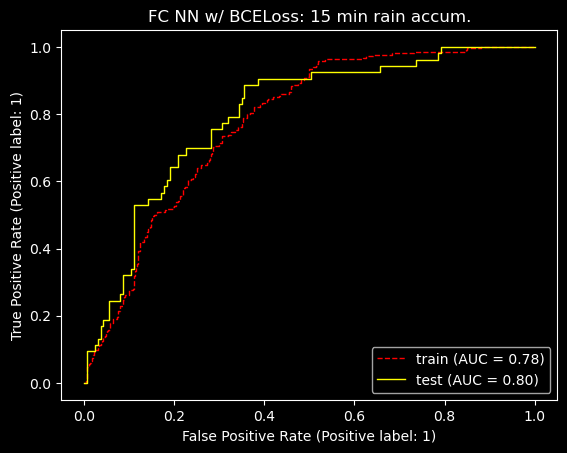

In [53]:
%%time
# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    #X = data[features_15]
    X = data[best_params['features']] # using features from grid search
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = best_params['hidden_size']
    output_size = 1
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr'] # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = n_epochs
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')


print('hyperparameters:')
print(best_params)
print('epochs: ', n_epochs)

print("\n")

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# recall
test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='binary')
print('\n')
print(f'Recall (test): {test_recall_score}')


# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 15 min rain accum.');

In [61]:

# save final model weights
model.state_dict()
# torch.save(model.state_dict(), 'model.pth')  

OrderedDict([('fc1.weight',
              tensor([[ 0.6005],
                      [-0.2597],
                      [ 0.2719],
                      [-0.2113],
                      [-1.1182],
                      [ 0.6940],
                      [ 0.4179],
                      [ 0.4002],
                      [-0.3426],
                      [-0.2144]])),
             ('fc1.bias',
              tensor([ 0.1415,  0.6376, -0.7102, -0.5711,  0.5546, -0.4944, -0.0752, -0.1302,
                      -0.3588,  0.0697])),
             ('fc_out.weight',
              tensor([[ 0.5221, -0.5871,  0.3346, -0.6367, -1.0349, -0.0874, -0.4202, -0.1234,
                        0.3259,  0.1456]])),
             ('fc_out.bias', tensor([-0.1345]))])

In [54]:
best_params['features']

['peak_i15_mmh']

In [55]:
pd.DataFrame(np.round(y_test_pred.detach().numpy())).value_counts(normalize=True)

0.0000000   0.9305556
1.0000000   0.0694444
dtype: float64

## Assess the wrong predictions <a id="matrix">
- is the loss for test set high due to outliers?

In [56]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [57]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.detach().numpy(), columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred.detach().numpy()).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred.detach().numpy()
test_assess

y_test  y_test_pred  pred_correct  y_test_pred_proba
0         1            0         False          0.1995296
1         1            0         False          0.2524829
2         0            0          True          0.1208661
3         0            0          True          0.3557085
4         1            1          True          0.5202132
..      ...          ...           ...                ...
211       0            0          True          0.0753663
212       0            0          True          0.1351486
213       1            0         False          0.1902021
214       0            0          True          0.0941285
215       0            0          True          0.0951560

[216 rows x 4 columns]

In [59]:
# the confusion matrix is pretty bad
# a lot of false negatives
test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()

pred_correct  False  True
y_test                   
0                 6   157
1                44     9

In [48]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [51]:
# check geographical distribution of test set labels
df.loc[y_test.index,'pred_correct'] = y_test == y_test_pred

df.groupby(['state'])['pred_correct'].value_counts(normalize=False).unstack()#.fillna(0).style.format("{:,.1%}")

pred_correct  False
state              
AZ               12
CA              151
CO               43
NM               10

In [ ]:
y_test = torch.tensor(y_test.values).float().view(-1, 1)

In [347]:
23 / (23 + 30)

0.4339622641509434

prior to recall optimization

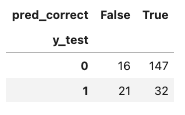

In [341]:
21 / (21 + 32)

0.39622641509433965

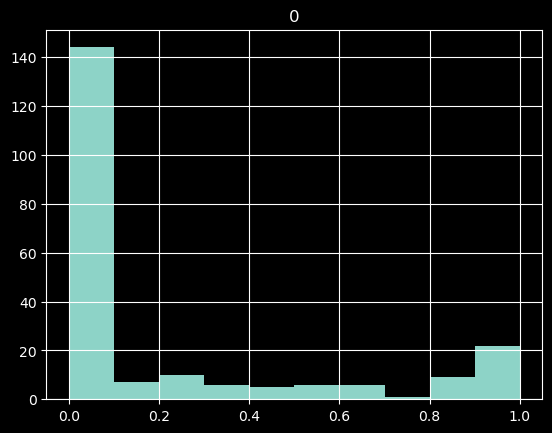

In [344]:
pd.DataFrame(y_test_pred.detach().numpy()).hist();

prior to recall optimization

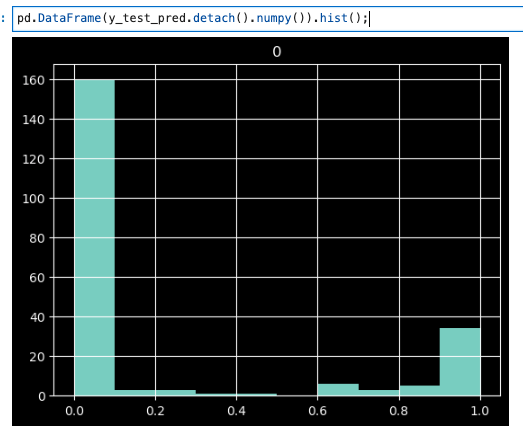

In [345]:
# let's examine the probability of these false negatives
false_negatives = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]
false_negatives

y_test  y_test_pred  pred_correct  y_test_pred_proba
1         1            0         False          0.4300812
13        1            0         False          0.0798314
14        1            0         False          0.0992397
17        1            0         False          0.0031281
20        1            0         False          0.0942906
54        1            0         False          0.0010656
60        1            0         False          0.0091040
73        1            0         False          0.1902177
81        1            0         False          0.2024042
100       1            0         False          0.0212390
104       1            0         False          0.0792876
114       1            0         False          0.0013446
116       1            0         False          0.0220205
119       1            0         False          0.3635658
120       1            0         False          0.0000001
147       1            0         False          0.0128403
149       1            0         False          0.0002781
155       1            0         False          0.1481572
157       1            0         False          0.0000012
159       1            0         False          0.0071279
177       1            0         False          0.2708920
188       1            0         False          0.0511159
209       1            0         False          0.4867129

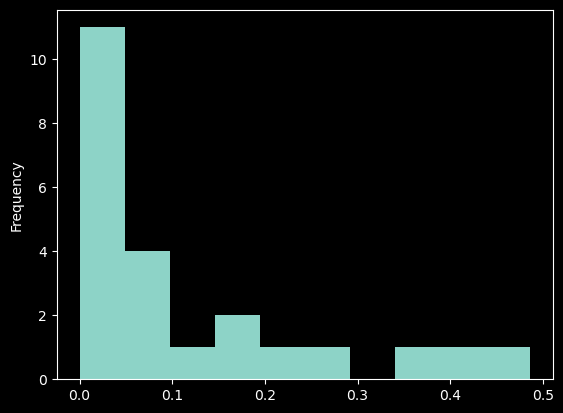

In [346]:
# the false negatives have really low predicted probabilities
false_negatives['y_test_pred_proba'].plot(kind='hist');

prior to recall optimization

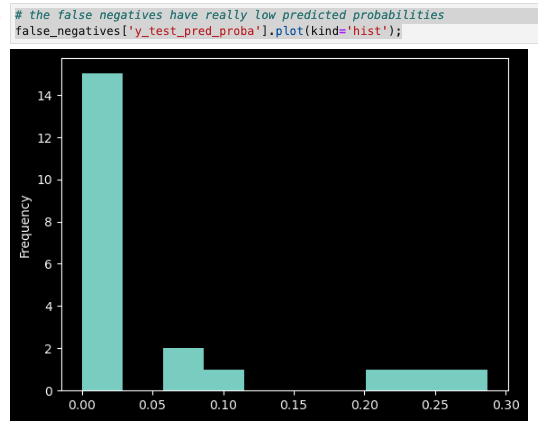

## Prior Iterations <a id="prior"> 

- we had higher AUC but also higher False Negatives.
- trying to strike balance between model scalability, performance, and preventing false negatives.
    - We don't need to include details on this in the report

In [ ]:
# let's do the same assessment with our previous model iteration that had low test_loss

In [276]:
n_epochs = 100

In [277]:
%%time
# GRID SEARCH CV

# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()

    X = data[features_15[:-2]] # exclude the two additional features
    y = data['response']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)

    # GRID SEARCH
    param_grid = {
    'hidden_size': [10, 100, 250, 500],
    'dropout_rate': [0.05, 0.10, 0.15, 0.20],
    'lr': [0.0001, 0.001, 0.01],
    }
    
    best_accuracy = 0.0
    best_recall = 0.0
    best_auc = 0.0
    best_params ={}
    
    for params in ParameterGrid(param_grid):
        input_size = X_train.shape[1]
        hidden_size = params['hidden_size']
        output_size = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['lr']

        model = Net(input_size, hidden_size, output_size, dropout_rate)

        criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
        
        # best_params = grid_search.best_params_
        # best_model = grid_search.best_estimator_
     
        num_epochs = n_epochs

        # # empty df to track loss over epochs
        # loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])

        for epoch in range(num_epochs):
            y_train_pred = model(X_train)
            loss = criterion(y_train_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
#         if epoch%5 ==0:
#             y_train_pred = model(X_train)
#             y_test_pred = model(X_test)

#             train_loss = criterion(y_train_pred, y_train)
#             val_loss = criterion(y_test_pred, y_test)
            
#             loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
#             loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

# fig = loss_df.plot()
# fig.set_xlabel('epochs')
# fig.set_ylabel('loss')
# fig.set_title('Loss over Epochs');

        # now "final" outputs
        y_train_pred = model(X_train)
        #y_train_prob = torch.sigmoid(y_train_pred) # already a probability

        y_test_pred = model(X_test)
        # y_test_prob = torch.sigmoid(y_test_pred) # already a probability

        train_loss = criterion(y_train_pred, y_train)
        val_loss = criterion(y_test_pred, y_test)

        test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
        test_accuracy = (test_pred_correct / y_test.shape[0])[0]
        
        test_recall_score = recall_score(y_test, np.round(y_test_pred.detach().numpy()), average='micro')

        # extract AUC for printing
        auc_test = roc_auc_score(
            y_test.detach().numpy(), 
            y_test_pred.detach().numpy()
        )
        
        # # evaluating parameters on test accuracy
        # if test_accuracy > best_accuracy:
        #     best_accuracy = test_accuracy
        #     best_params = params
            
        # evaluating parameters on test recall
        if test_recall_score > best_recall:
            best_recall = test_recall_score
            best_params = params
            
        # # evaluating parameters on test AUC
        # if auc_test > best_auc:
        #     best_auc = auc_test
        #     best_params = params

    # save final model weights
    # torch.save(model.state_dict(), 'model.pth')     
    
    print('best hyperparameters:')
    print(best_params)
    
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')

    print("\n")

    # accuracy
    train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
    train_accuracy = (train_pred_correct / y_train.shape[0])[0]
    print(f'Training accuracy: {train_accuracy}')

    test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
    test_accuracy = (test_pred_correct / y_test.shape[0])[0]
    print(f'Test accuracy: {test_accuracy}')

    # AUC
    print("\n")
    print(f'AUC (test): {auc_test}')
    # f1
    f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
    print(f'F1 Score (test): {f1_output}')

best hyperparameters:
{'dropout_rate': 0.05, 'hidden_size': 100, 'lr': 0.01}
Training loss: 0.15981507301330566
Validation loss: 0.470291405916214


Training accuracy: 0.9322617680826636
Test accuracy: 0.8211009174311926


AUC (test): 0.887707261292167
F1 Score (test): 0.6666666666666665
CPU times: user 4min 47s, sys: 3.53 s, total: 4min 51s
Wall time: 14.4 s


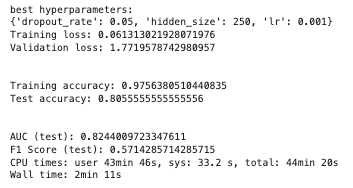

In [278]:
# # previously tuned parameters that worked well
# best_params = {
#     'dropout_rate': 0.05,
#     'hidden_size': 10,
#     'lr': 0.0001
# }

In [279]:
n_epochs = 5_000

hyperparameters:
{'dropout_rate': 0.05, 'hidden_size': 100, 'lr': 0.01}
epochs:  5000


Training loss: 0.0456533245742321
Validation loss: 2.376729726791382


Training accuracy: 0.983926521239954
Test accuracy: 0.7889908256880734


F1 Score (test): 0.6034482758620691
AUC (test): 0.8600343053173242


CPU times: user 5min 8s, sys: 2.93 s, total: 5min 11s
Wall time: 14.5 s


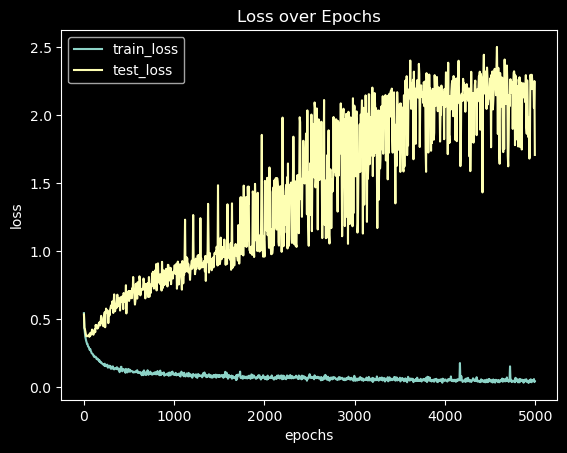

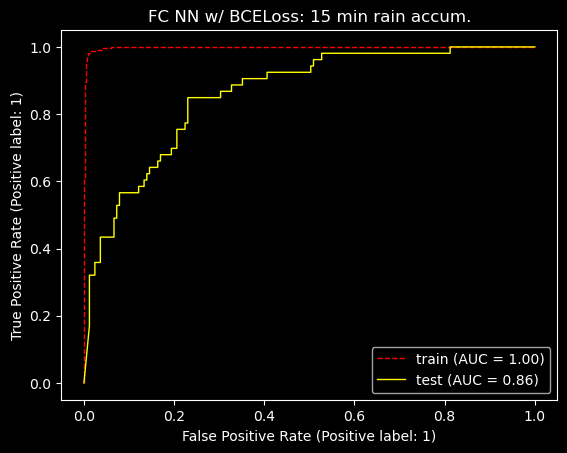

In [280]:
%%time
# 15 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_15[:-2]]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = best_params['hidden_size']
    output_size = 1
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr'] # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = n_epochs
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')


print('hyperparameters:')
print(best_params)
print('epochs: ', n_epochs)

print("\n")

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 15 min rain accum.');

In [281]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test.detach().numpy(), columns=['y_test']).astype(int)
# predicted values
test_assess['y_test_pred'] = np.round(y_test_pred.detach().numpy()).astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred.detach().numpy()
test_assess

y_test  y_test_pred  pred_correct  y_test_pred_proba
0         1            0         False          0.0419769
1         0            0          True          0.0000000
2         0            1         False          0.9837437
3         0            0          True          0.0000003
4         0            1         False          0.9499037
..      ...          ...           ...                ...
213       1            0         False          0.4699014
214       0            1         False          0.7389097
215       1            1          True          0.9871778
216       0            0          True          0.0000000
217       0            0          True          0.0000000

[218 rows x 4 columns]

In [282]:
# the confusion matrix is really pretty bad
# even more false negatives!
test_assess.groupby(['y_test'])['pred_correct'].value_counts().unstack()

pred_correct  False  True
y_test                   
0                28   137
1                18    35

with "macro" average (does not take class imbalance into account)

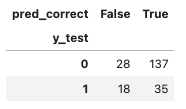

with "micro" average

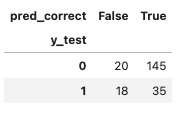

In [271]:
18 / (18+35)

0.33962264150943394

with "binary" average

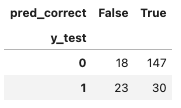

In [264]:
23 / (23 + 30)

0.4339622641509434

before maximing recall

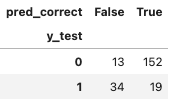

In [262]:
# let's examine the probability of these false negatives
false_negatives = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]
false_negatives

y_test  y_test_pred  pred_correct  y_test_pred_proba
16        1            0         False          0.3881507
43        1            0         False          0.2440847
45        1            0         False          0.0770734
51        1            0         False          0.3869691
53        1            0         False          0.3794882
66        1            0         False          0.0192388
67        1            0         False          0.4561952
69        1            0         False          0.3699151
73        1            0         False          0.4835797
80        1            0         False          0.3902963
83        1            0         False          0.3240828
91        1            0         False          0.3898517
108       1            0         False          0.0391729
126       1            0         False          0.4518199
156       1            0         False          0.4126339
158       1            0         False          0.1519589
168       1            0         False          0.4095282
170       1            0         False          0.3508242
177       1            0         False          0.0893015
185       1            0         False          0.4654074
192       1            0         False          0.0972480
202       1            0         False          0.2449678
213       1            0         False          0.3360306

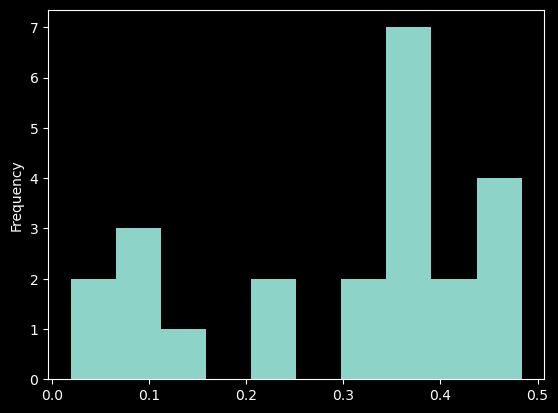

In [263]:
# the false negatives have really low predicted probabilities
false_negatives['y_test_pred_proba'].plot(kind='hist');

10,000 epochs with 1 hidden layer, before landslide risk

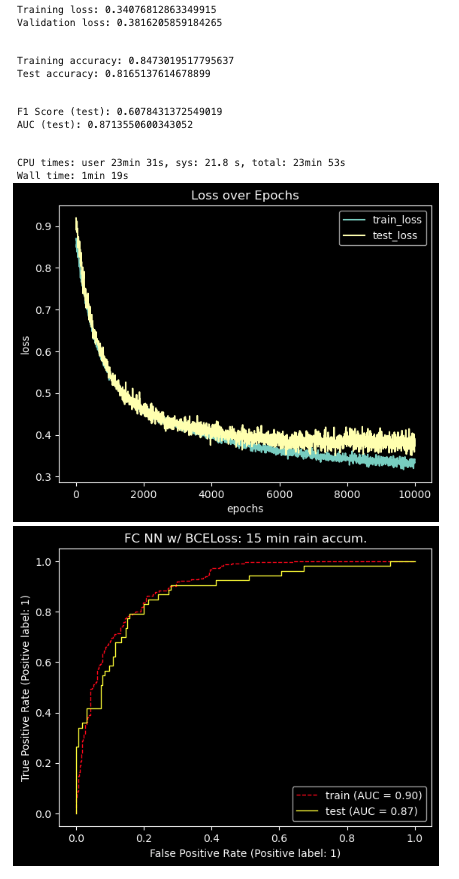

 1,000 epochs
 
 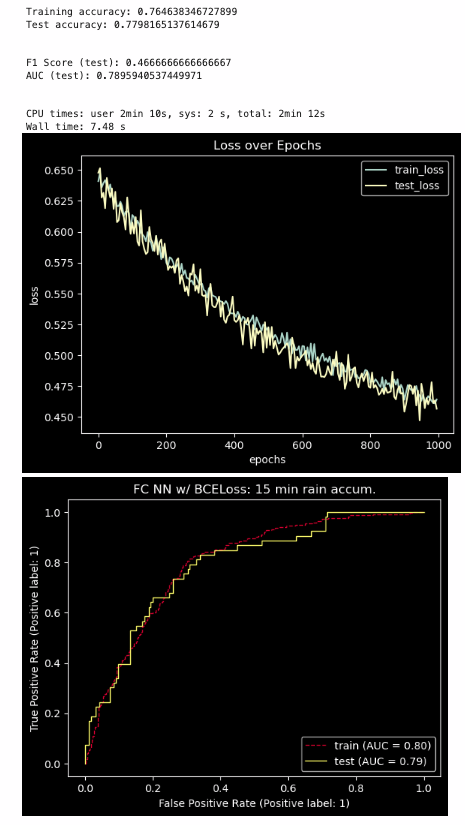

Training loss: 0.018063928931951523
Validation loss: 2.569516897201538


Training accuracy: 0.9919632606199771
Test accuracy: 0.8211009174311926


F1 Score (test): 0.6548672566371682
AUC (test): 0.869182389937107


CPU times: user 4min 46s, sys: 6.38 s, total: 4min 52s
Wall time: 14.1 s


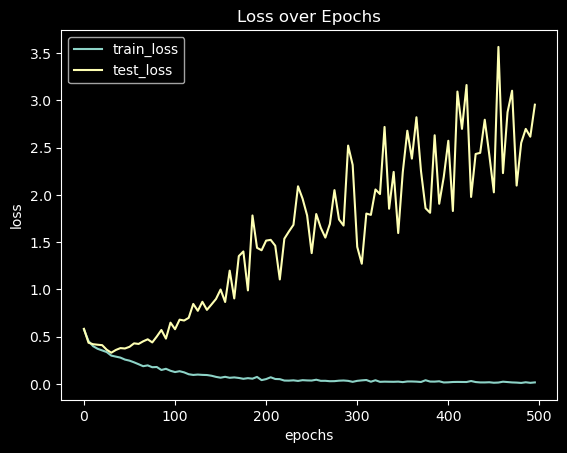

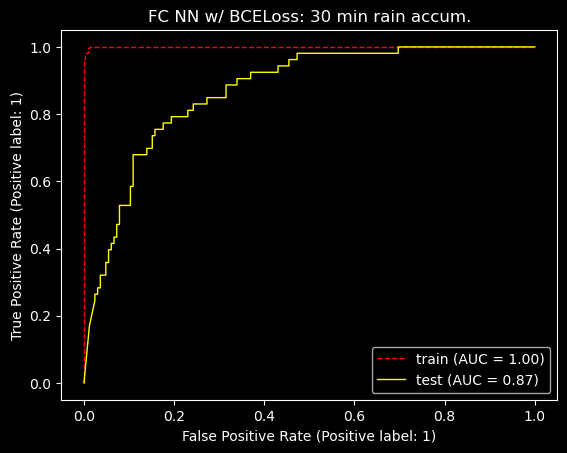

In [11]:
%%time
# 30 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_30]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
       
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 500
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 30 min rain accum.');

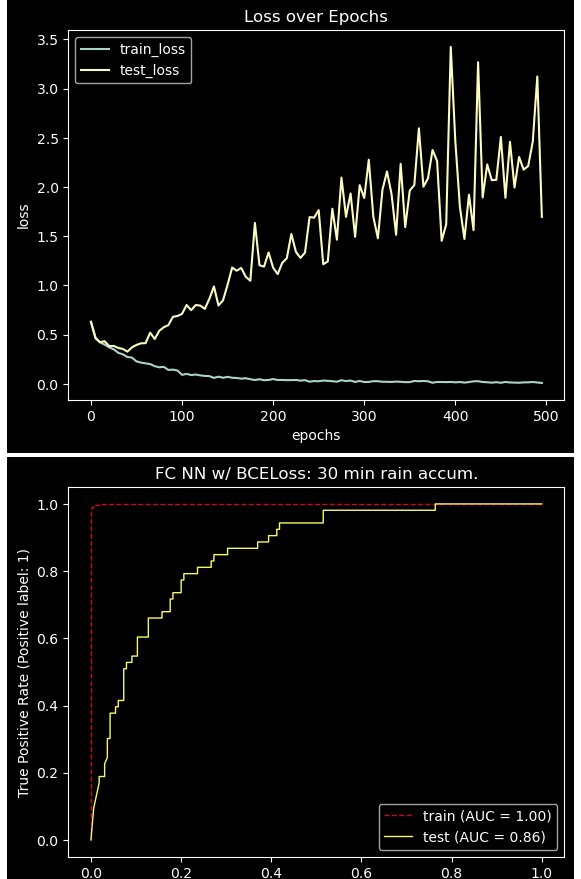

Training loss: 0.01925519108772278
Validation loss: 1.5104376077651978


Training accuracy: 0.9873708381171068
Test accuracy: 0.7935779816513762


F1 Score (test): 0.5945945945945946
AUC (test): 0.8695254431103487


CPU times: user 25min 25s, sys: 25 s, total: 25min 50s
Wall time: 1min 38s


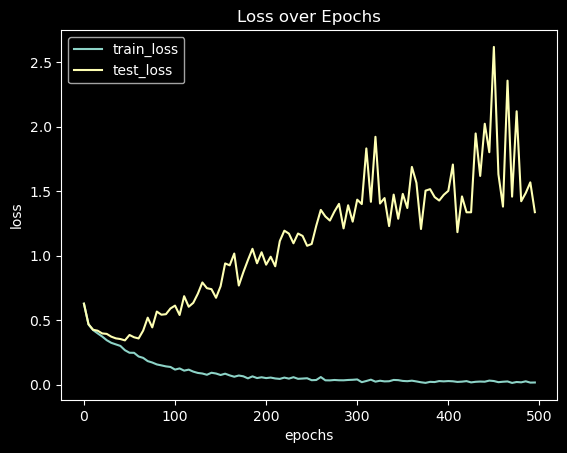

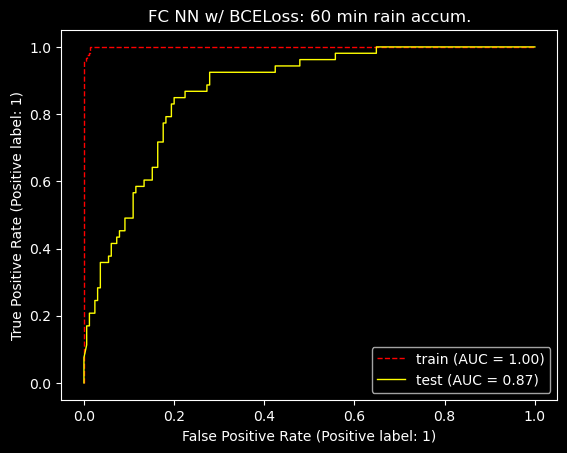

In [16]:
%%time
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = df.copy()
    
    X = data[features_60]
    y = data['response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
        
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 500
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred = model(X_train)
            y_test_pred = model(X_test)

            train_loss = criterion(y_train_pred, y_train)
            val_loss = criterion(y_test_pred, y_test)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().numpy().reshape(1)[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().numpy().reshape(1)[0]

fig = loss_df.plot()
fig.set_xlabel('epochs')
fig.set_ylabel('loss')
fig.set_title('Loss over Epochs');

# now final outputs
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)
# save final model weights
# torch.save(model.state_dict(), 'model.pth')

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')


# extract AUC for printing
auc_test = roc_auc_score(
    y_test.detach().numpy(), 
    y_test_pred.detach().numpy()
)
print(f'AUC (test): {auc_test}')
print('\n')

# and plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum.');